# To Grant or Not to Grant: Deciding on Compensation Benefits 

### Machine Learning Group Project 2024/2025 - Group 52


__Members:__
- Diogo Rodrigues _(20240512@novaims.unl.pt)_
- Alexandre Gonçalves _(20240738@novaims.unl.pt)_
- Pedro Costa _(20222121@novaims.unl.pt)_
- Santiago Taylor _(20240542@novaims.unl.pt)_
- Lena Hermann _(20241446@novaims.unl.pt)_

# Notebook 04 - Modeling and Assessment

## Table of Content
<a id='top'></a>
[1. Set-Up and Data Loading](#dataload) <br>
&nbsp;&nbsp;&nbsp;[1.1 Import the Needed Libraries](#import_libaries) <br>
&nbsp;&nbsp;&nbsp;[1.2 Define Functions](#functions) <br>
&nbsp;&nbsp;&nbsp;[1.3 Load the Data](#load_data) <br>
[2. Modeling and Evaluation](#modeling) <br>
&nbsp;&nbsp;&nbsp;[2.1 Baseline](#baseline) <br>
&nbsp;&nbsp;&nbsp;[2.2 Logistic Regression](#logistic_regression) <br>
&nbsp;&nbsp;&nbsp;[2.3 Naive Bayes](#nb) <br>
&nbsp;&nbsp;&nbsp;[2.4 K-Nearest Neighbors](#knn) <br>
&nbsp;&nbsp;&nbsp;[2.5 Neural Networks](#nn) <br>
&nbsp;&nbsp;&nbsp;[2.6 Decision Trees](#dt) <br>
&nbsp;&nbsp;&nbsp;[2.7 Ensemble Learning](#el) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.7.1 Bagging Classifier](#bagging) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.7.2 Random Forest Classifier](#random_forest) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.7.3 XGBoost](#xgboost) <br>
&nbsp;&nbsp;&nbsp;[2.8 Support Vector Machines](#svm) <br>
[3. Comparison of all Models](#comparison) <br>
[4. Feature Importance](#feature_importance) <br>
[5. Best Model vs. Stacking](#stacking) <br>

## 1. Set-Up and Data Loading <a id='dataload'></a>
[to the top](#top)

### 1.1 Import the Needed Libraries <a id='import_libaries'></a>

In [2]:
# Core Functions
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import zipfile #to open zipfile
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 60)
from scipy.stats import mode

# Encoding and Scaling
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

# Model Selection
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import PredefinedSplit

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC


# Model Assessment
from sklearn.metrics import classification_report, f1_score, confusion_matrix


import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set a global seed
np.random.seed(42)

### 1.2 Define Functions <a id='functions'></a>

In [7]:
# Define functions to use as pipeline

# Training and Evaluation
def train_and_evaluate(model, X_train, X_val, y_train, y_val):
    """
    Train and evaluate a single model on a fixed training and validation set.

    Parameters:
        model: The machine learning model to train.
        X_train (pd.DataFrame): Training feature set.
        X_val (pd.DataFrame): Validation feature set.
        y_train (pd.Series): Training labels.
        y_val (pd.Series): Validation labels.

    Returns:
        dict: A dictionary containing training time, train F1-score, and validation F1-score.
    """

    # Training and timing
    start = time.perf_counter()
    model.fit(X_train, y_train)
    end = time.perf_counter()

    # Predictions and scoring
    train_f1 = round(f1_score(y_train, model.predict(X_train), average='macro'), 3)
    val_f1 = round(f1_score(y_val, model.predict(X_val), average='macro'), 3)
    elapsed_time = round(end - start, 3)

    return elapsed_time, train_f1, val_f1


def compare_results(models, X_train, X_val, y_train, y_val):
    """
    Evaluate multiple models using cross-validation and return results in a DataFrame.
    """
    results = []
    for name, model in models:
        print(f"Evaluating model: {name}...")
        time, train_f1, val_f1 = train_and_evaluate(model, X_train, X_val, y_train, y_val)
        results.append({
            "Model": name,
            "Time (s)": time,
            "Train F1-Score": train_f1,
            "Validation F1-Score": val_f1
        })

    results_df = pd.DataFrame(results)
    return results_df


# Comined Dataset
def create_combined_dataset(X_train, X_val, y_train, y_val):
    """
    Combines train and validation datasets and creates a test fold index.
    """
    # Combine train and validation datasets
    X_combined = np.concatenate([X_train, X_val])
    y_combined = np.concatenate([y_train, y_val])
    
    # Create a test fold index (-1 for train, 0 for validation)
    test_fold = [-1] * len(X_train) + [0] * len(X_val)
    
    # Print debug information
    print('Test fold: ', len(test_fold))
    print('X_combined: ', len(X_combined))
    print('y_combined: ', len(y_combined))
    
    return X_combined, y_combined, test_fold


# Hyperparameter Tuning
def hyperparameter_tuning(estimator, param_grid, test_fold, X_combined, y_combined):
    """Perform hyperparameter tuning with Predefined Split"""
    ps = PredefinedSplit(test_fold=test_fold)
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='f1_macro', verbose=1, cv=ps)
    grid_search.fit(X_combined, y_combined)
    print(f"The best score is {grid_search.best_score_}")
    print(f"With the parameters: {grid_search.best_params_}")
    return grid_search.best_params_


# Evaluation Functions
def classification_report_print(y_test, y_pred, model):
    """Print classification report."""
    print("\nClassification Report for {}:".format(model))
    print('')
    print(classification_report(y_test, y_pred))

def conf_matrix_plot(y_true, y_pred, labels):
    """Plot confusion matrix."""
    unique_labels = np.unique(np.concatenate([y_true, y_pred]))
    cnf_matrix = confusion_matrix(y_true, y_pred, labels=unique_labels)
    df_cm = pd.DataFrame(cnf_matrix, index=unique_labels, columns=unique_labels)
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()



### 1.3 Load the Data <a id='load_data'></a>
[to the top](#top)

Replace the following lines of codes with the processed train and test files.

In [4]:
X_train = pd.read_csv("C:/Users/Diogo Rodrigues/OneDrive/Desktop/PRE PROCESSING/MINHA PARTE/X_train_filtered.csv")
X_test = pd.read_csv("C:/Users/Diogo Rodrigues/OneDrive/Desktop/PRE PROCESSING/MINHA PARTE/X_test_filtered.csv")
X_val= pd.read_csv("C:/Users/Diogo Rodrigues/OneDrive/Desktop/PRE PROCESSING/MINHA PARTE/X_val_filtered.csv")
y_train = pd.read_csv("C:/Users/Diogo Rodrigues/OneDrive/Desktop/PRE PROCESSING/y_train_processed.csv")
y_test= pd.read_csv("C:/Users/Diogo Rodrigues/OneDrive/Desktop/PRE PROCESSING/y_test_processed.csv")
y_val= pd.read_csv("C:/Users/Diogo Rodrigues/OneDrive/Desktop/PRE PROCESSING/y_val_processed.csv")

In [5]:
len(X_train.columns)

46

In [29]:
X_test.shape

(114806, 46)

In [37]:
print(X_train.columns)

Index(['Age at Injury', 'Average Weekly Wage', 'Claim Identifier',
       'Number of Dependents', 'Accident_to_C2_Lag', 'Accident Date_Month',
       'Accident_Day', 'Accident_Month_Cos', 'Assembly Date_Day',
       'C-2 Date_Day', 'COVID-19 Indicator_N', 'Attorney/Representative_N',
       'Wage_Group', 'Carrier Name Grouped_A I U INSURANCE COMPANY',
       'Carrier Name Grouped_AMERICAN ZURICH INSURANCE CO',
       'Carrier Name Grouped_CHARTER OAK FIRE INS CO',
       'Carrier Name Grouped_INDEMNITY INS. OF N AMERICA',
       'Carrier Name Grouped_INDEMNITY INSURANCE CO OF',
       'Carrier Name Grouped_LM INSURANCE CORP',
       'Carrier Name Grouped_NEW HAMPSHIRE INSURANCE CO',
       'Carrier Name Grouped_NYC TRANSIT AUTHORITY',
       'Carrier Name Grouped_Other',
       'Carrier Name Grouped_POLICE, FIRE, SANITATION',
       'Carrier Name Grouped_SAFETY NATIONAL CASUALTY CORP',
       'Carrier Name Grouped_STATE INSURANCE FUND'],
      dtype='object')


## 2. Modeling and Evaluation <a id='modeling'></a>
[to the top](#top)

------------------ _DELETE THE FOLLOWING CODE FOR FINAL VERSION (UNTIL BASELINE), THIS IS JUST TO TEST IF THE FUNCTIONS WORK_ ------------------

In [145]:
# Example Dataset to test the functions
train_temp = train_df.copy()
train_temp = train_temp.drop(columns=['OIICS Nature of Injury Description', 'C-3 Date', 'First Hearing Date', 'IME-4 Count'])
train_temp = train_temp.dropna()
len(train_temp)

473997

In [149]:
# Split
train_data = train_temp.iloc[:1400]  
val_data = train_temp.iloc[1400:1700]  
test_data = train_temp.iloc[1700:2000]

# Features and target
X_train = train_data.drop(columns=['Claim Injury Type'])
y_train = train_data['Claim Injury Type']


y_val = val_data['Claim Injury Type']

X_test = test_data.drop(columns=['Claim Injury Type'])
y_test = test_data['Claim Injury Type']

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 1400
Validation size: 300
Test size: 300


In [27]:
# Encoding the target variable "Claim Injury Type"
target_encoder = LabelEncoder()
y_train_df_encode = target_encoder.fit_transform(y_train)
y_val_df_encode = target_encoder.transform(y_val)
y_test_df_encode = target_encoder.transform(y_test)

array([4, 3, 2, ..., 1, 1, 1], dtype=int64)

In [33]:

print("Train Shape:", X_train.shape)
print("Validation Shape:", X_val.shape)
print("Test Shape:", X_test.shape)


Train Shape: (366640, 25)
Validation Shape: (91844, 25)
Test Shape: (387975, 25)


In [152]:
X_train_df_encode = pd.DataFrame(X_train_df_encode)
y_train_df_encode = pd.Series(y_train_df_encode)

### 2.1 Baseline <a id='baseline'></a>
[to the top](#top)

As a baseline, we will just predict the majority class.

In [8]:
# Predict the majority class for all instances as baseline
majority_class = mode(y_train)[0][0]  

y_pred_baseline = [majority_class] * len(y_test)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
print(f"Baseline Model F1 Score (predicting majority class): {baseline_f1:.2f}")

y_pred_baseline_original = y_pred_baseline

# Classification report with the original labels
classification_report_print(y_test, y_pred_baseline_original, 'Baseline Model')

Baseline Model F1 Score (predicting majority class): 0.08

Classification Report for Baseline Model:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2496
         1.0       0.51      1.00      0.67     58216
         2.0       0.00      0.00      0.00     13781
         3.0       0.00      0.00      0.00     29702
         4.0       0.00      0.00      0.00      9656
         5.0       0.00      0.00      0.00       842
         6.0       0.00      0.00      0.00        19
         7.0       0.00      0.00      0.00        94

    accuracy                           0.51    114806
   macro avg       0.06      0.12      0.08    114806
weighted avg       0.26      0.51      0.34    114806



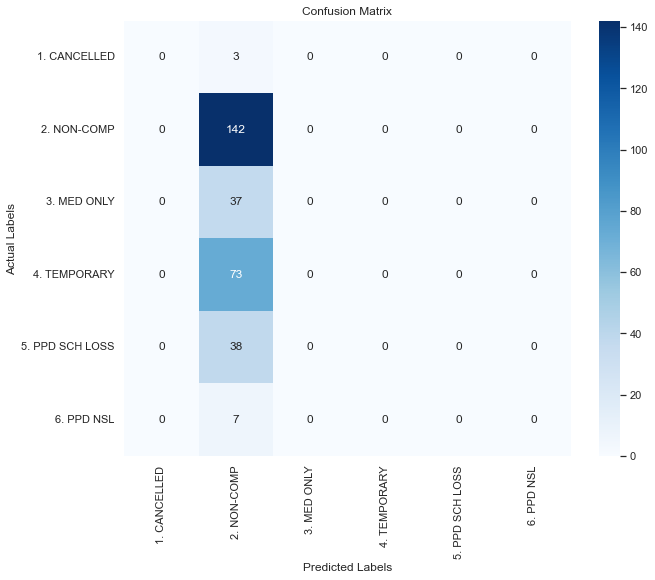

In [154]:
# Plot confusion matrix

labels=target_encoder.classes_
conf_matrix_plot(y_test, y_pred_baseline_original, labels)

### 2.2 Logistic Regression <a id='logistic_regression'></a>
[to the top](#top)

Step 1: Create model and define hyperparameter grid for Logistic Regression

In [10]:
# Create model
model_lr_default = LogisticRegression(multi_class='multinomial')
model_lr = LogisticRegression(multi_class='multinomial')

# Define hyperparameter grid
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],               # Regularization strength (smaller values mean stronger regularization)
    "solver": ["lbfgs", "saga", "newton-cg"],   # Solvers that support multinomial logistic regression
    "max_iter": [100, 500, 1000]                # Maximum number of iterations for solver convergence
}

Step 2: Perform hyperparameter tuning

In [8]:
X_combined, y_combined, test_fold = create_combined_dataset(X_train, X_val, y_train, y_val)

Test fold:  438420
X_combined:  438420
y_combined:  438420


In [11]:
# Tune hyperparameters using the training set
best_params_lr = {'C': 100, 'max_iter': 100, 'solver': 'lbfgs'}
model_lr.set_params(**best_params_lr)

LogisticRegression(C=100, multi_class='multinomial')

Step 3: Train default model and model with best parameter setting and evaluate

_RICARDO SAID WE DONT NEED TO TRAIN THE BEST MODEL AGAIN AFTER HYPERPARAMETER BUT I DID IT TO COMPARE WITH DEFAULT, should maybe not be done if we use the whole dataset because then it is just a wate of computational time_

In [13]:
models_lr = [
    ("LR Default", model_lr_default),
    ("LR Best Params", model_lr)
]

In [14]:
# Train and evaluate on validation set
results_lr = compare_results(models_lr, X_train, X_val, y_train, y_val)
results_lr

Evaluating model: LR Default...
Evaluating model: LR Best Params...


Model  Time (s)  Train F1-Score  Validation F1-Score
0      LR Default    12.518           0.273                0.279
1  LR Best Params    11.977           0.275                0.280

Step 4: Evaluate the choosen Model on our Test Set

In [21]:
# Evaluate on the test set
y_test_pred_lr = model_lr.predict(X_test)

# Decode predictions

# Calculate and save the F1 macro score on test for the best parameter model
test_f1_lr_best = round(f1_score(y_test, y_test_pred_lr, average='macro'), 3)
results_lr_best = results_lr[results_lr["Model"].str.contains("Best Params")].copy()
results_lr_best["Test F1-Score"] = test_f1_lr_best

# Classification report with the original labels
classification_report_print(y_test, y_test_pred_lr, 'Logistic Regression Model')


Classification Report for Logistic Regression Model:

              precision    recall  f1-score   support

         0.0       0.13      0.01      0.02      2496
         1.0       0.80      0.99      0.89     58216
         2.0       0.21      0.02      0.04     13781
         3.0       0.70      0.81      0.75     29702
         4.0       0.64      0.45      0.53      9656
         5.0       0.00      0.00      0.00       842
         6.0       0.00      0.00      0.00        19
         7.0       0.07      0.03      0.04        94

    accuracy                           0.75    114806
   macro avg       0.32      0.29      0.28    114806
weighted avg       0.67      0.75      0.69    114806



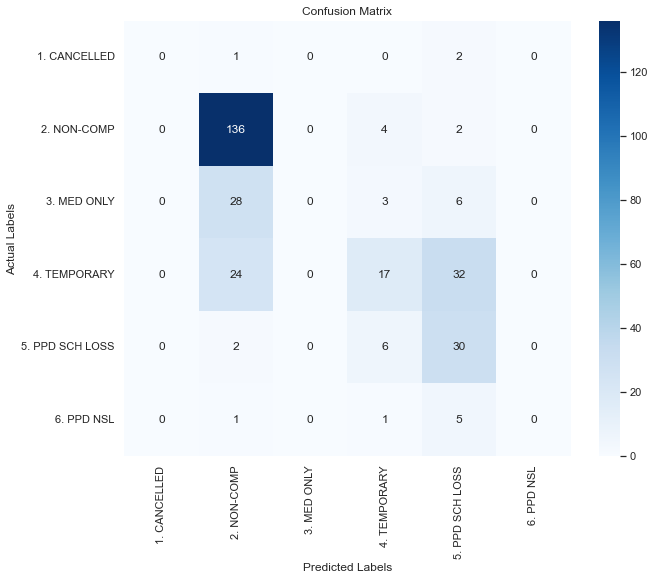

In [161]:
# Plot confusion matrix for test data
labels=target_encoder.classes_
conf_matrix_plot(y_test, y_test_pred_decoded_lr, labels)

__Findings (need to update):__
- __Dominant Predictions in Major Classes:__ The model tends to classify most instances as "NON-COMP" or "TEMPORARY," which may be due to the model biasing towards these dominant classes in order to maximize accuracy. This bias indicates that the model may not be capturing the nuances necessary to distinguish minority classes effectively.
- __Poor Performance in Minority Classes:__ For classes like "CANCELLED," "PTD," and "DEATH," the model struggles to make correct predictions. For example, "CANCELLED" instances are often misclassified as "NON-COMP," and the model almost never predicts "DEATH" correctly. This is problematic, as correct classification in these classes could be crucial depending on the application.
- __Overlapping Classes:__ There are high off-diagonal values indicating confusion between classes like "MED ONLY" and "TEMPORARY," and between "PPD SCH LOSS" and "TEMPORARY." This suggests that the model finds these classes challenging to differentiate, potentially due to similar feature distributions or because these categories have overlapping characteristics.

Step 5: Prediction on Submission Test Data

_NAME DIFFERENT SO WE DONT CONFUSE OUR TEST DATA WITH THE SUBMISSION TEST DATA_

In [15]:
# Predict on the test set
y_test_pred_lr = model_lr.predict(X_test)
y_test_decoded_lr = target_encoder.inverse_transform(y_test)
y_test_decoded_lr

NameError: name 'target_encoder' is not defined

In [163]:
unique_values, counts = np.unique(y_test_decoded_lr, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

2. NON-COMP: 192
4. TEMPORARY: 31
5. PPD SCH LOSS: 77


In [25]:
# Create a submission DataFrame
submission_lr = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_decoded_lr
})

# Save the submission file
submission_lr.to_csv('submission_lr.csv', index=False)
print("Submission file saved as 'submission_lr.csv'")

Submission file saved as 'submission_lr.csv'


In [ ]:
submission_lr

Claim Identifier   Prediction
0                6165911  2. NON-COMP
1                6166141  2. NON-COMP
2                6165907  2. NON-COMP
3                6166047  2. NON-COMP
4                6166102  2. NON-COMP
...                  ...          ...
387970           6553137  2. NON-COMP
387971           6553119  2. NON-COMP
387972           6553542  2. NON-COMP
387973           6553455  2. NON-COMP
387974           6553594  2. NON-COMP

[387975 rows x 2 columns]

### 2.3 Naive Bayes <a id='nb'></a>
[to the top](#top)

In [38]:
# Create model
model_gauss_nb_default = GaussianNB()
model_gauss_nb = GaussianNB()
model_multi_nb_default = MultinomialNB()
model_multi_nb = MultinomialNB()

# Define hyperparameter grid
param_grid_gauss = {
    "var_smoothing": [1e-12, 1e-10, 1e-9, 1e-8, 1e-7]  #
}

# Define hyperparameter grid
param_grid_multi = {
    "alpha": [0.01, 0.1, 1, 10, 100],  # Laplace smoothing parameter
    "fit_prior": [True, False]         # Whether to learn class priors or use uniform distribution
}

In [35]:
# Tune hyperparameters using the training set
best_params_gauss_nb = hyperparameter_tuning(model_gauss_nb, param_grid_gauss, test_fold, X_combined, y_combined)
model_gauss_nb.set_params(**best_params_gauss_nb)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
The best score is 0.10972159974924883
With the parameters: {'var_smoothing': 1e-07}


GaussianNB(var_smoothing=1e-07)

In [39]:
# Tune hyperparameters using the training set
best_params_multi_nb = hyperparameter_tuning(model_multi_nb, param_grid_multi, test_fold, X_combined, y_combined)
model_multi_nb.set_params(**best_params_multi_nb)

Fitting 1 folds for each of 10 candidates, totalling 10 fits


ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Diogo Rodrigues\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Diogo Rodrigues\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Diogo Rodrigues\anaconda3\Lib\site-packages\sklearn\naive_bayes.py", line 759, in fit
    self._count(X, Y)
  File "c:\Users\Diogo Rodrigues\anaconda3\Lib\site-packages\sklearn\naive_bayes.py", line 881, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "c:\Users\Diogo Rodrigues\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1650, in check_non_negative
    raise ValueError("Negative values in data passed to %s" % whom)
ValueError: Negative values in data passed to MultinomialNB (input X)


In [40]:
models_nb = [
    ("Gaussian NB Default", model_gauss_nb_default),
    ("Gaussian NB Best Params", model_gauss_nb)
]

In [41]:
# Train and evaluate on validation set
results_nb = compare_results(models_nb, X_train, X_val, y_train, y_val)
results_nb

Evaluating model: Gaussian NB Default...
Evaluating model: Gaussian NB Best Params...


Model  Time (s)  Train F1-Score  Validation F1-Score
0      Gaussian NB Default     0.233           0.085                0.086
1  Gaussian NB Best Params     0.239           0.085                0.086

In [46]:
# Evaluate on the test set
y_test_pred_nb = model_gauss_nb_default.predict(X_test)


# Calculate and save the F1 macro score on test for the best parameter model
test_f1_nb_best = round(f1_score(y_test, y_test_pred_nb, average='macro'), 3)
results_nb_best = results_nb[results_nb["Model"].str.contains("Multinomial NB Best Params")].copy()
results_nb_best["Test F1-Score"] = test_f1_nb_best

# Classification report with the original labels
classification_report_print(y_test, y_test_pred_nb, 'Naive Bayes Model')


Classification Report for Naive Bayes Model:

              precision    recall  f1-score   support

         0.0       0.02      0.00      0.00      2496
         1.0       0.87      0.25      0.38     58216
         2.0       0.22      0.01      0.02     13781
         3.0       0.65      0.07      0.12     29702
         4.0       0.09      0.36      0.15      9656
         5.0       0.04      0.02      0.03       842
         6.0       0.00      0.79      0.00        19
         7.0       0.00      0.21      0.00        94

    accuracy                           0.17    114806
   macro avg       0.24      0.21      0.09    114806
weighted avg       0.64      0.17      0.24    114806



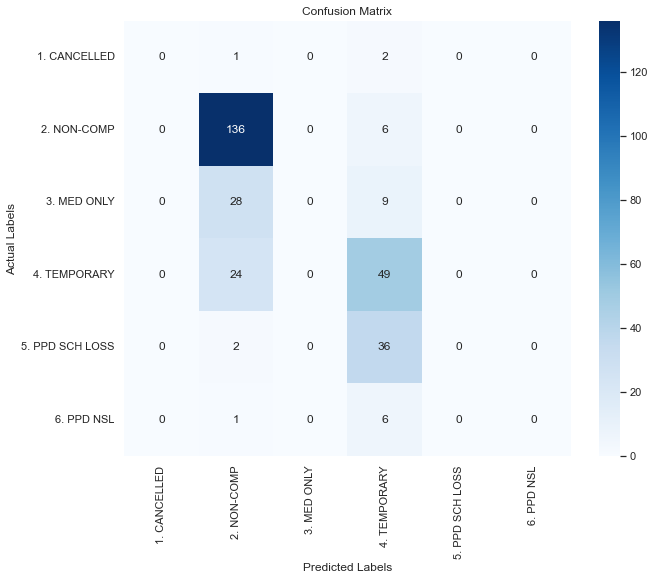

In [170]:
# Plot confusion matrix for test data
labels=target_encoder.classes_
conf_matrix_plot(y_test, y_test_pred_decoded_nb, labels)

__Findings:__
- __X:__ x

In [54]:
# Predict on the submission test set
y_test_pred_nb = model_multi_nb.predict(X_test_df_encode)
y_test_decoded_nb = target_encoder.inverse_transform(y_test_pred_nb)

In [55]:
unique_values, counts = np.unique(y_test_decoded_nb, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

2. NON-COMP: 138
4. TEMPORARY: 62


In [ ]:
# Create a submission DataFrame
submission_nb = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_decoded_nb
})

# Save the submission file
submission_nb.to_csv('submission_nb.csv', index=False)
print("Submission file saved as 'submission_nb.csv'")

### 2.4 K-Nearest Neighbor <a id='knn'></a>
[to the top](#top)

In [16]:
# Create KNN model
model_knn_default = KNeighborsClassifier()
model_knn = KNeighborsClassifier()

# Define parameter grid
param_grid_knn = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "algorithm": ['auto','kd_tree','brute'],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

In [17]:
# Tune hyperparameters using the training set
best_params_knn = {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
model_knn.set_params(**best_params_knn)

KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')

In [18]:
models_knn = [
    ("KNN Default", model_knn_default),
    ("KNN Best Params", model_knn)
]

In [20]:
# Train and evaluate on validation set
results_knn = compare_results(models_knn, X_train, X_val, y_train, y_val)
results_knn

Evaluating model: KNN Default...
Evaluating model: KNN Best Params...


Model  Time (s)  Train F1-Score  Validation F1-Score
0      KNN Default     0.087           0.392                0.314
1  KNN Best Params     0.071           1.000                0.324

In [22]:
# Evaluate on the test set
y_test_pred_knn = model_knn.predict(X_test)


# Calculate and save the F1 macro score on test for the best parameter model
test_f1_knn_best = round(f1_score(y_test, y_test_pred_knn, average='macro'), 3)
results_knn_best = results_knn[results_knn["Model"].str.contains("Best Params")].copy()
results_knn_best["Test F1-Score"] = test_f1_knn_best

# Classification report with the original labels
classification_report_print(y_test, y_test_pred_knn, 'K-Nearest Neighbor Model')


Classification Report for K-Nearest Neighbor Model:

              precision    recall  f1-score   support

         0.0       0.39      0.24      0.30      2496
         1.0       0.82      0.91      0.86     58216
         2.0       0.17      0.10      0.13     13781
         3.0       0.67      0.72      0.69     29702
         4.0       0.50      0.46      0.48      9656
         5.0       0.05      0.03      0.04       842
         6.0       0.00      0.00      0.00        19
         7.0       0.03      0.01      0.02        94

    accuracy                           0.70    114806
   macro avg       0.33      0.31      0.31    114806
weighted avg       0.66      0.70      0.68    114806



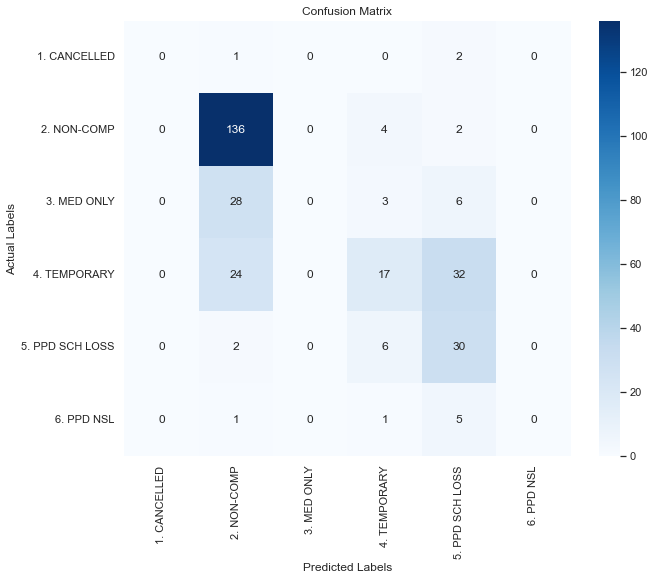

In [176]:
# Plot confusion matrix for test data
labels=target_encoder.classes_
conf_matrix_plot(y_test, y_test_pred_decoded_knn, labels)

__Findings:__
- __X:__ x

In [64]:
# Predict on the submission test set
y_test_pred_knn = model_knn.predict(X_test_df_encode)
y_test_decoded_knn = target_encoder.inverse_transform(y_test_pred_knn)

In [65]:
unique_values, counts = np.unique(y_test_decoded_knn, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

2. NON-COMP: 138
4. TEMPORARY: 18
5. PPD SCH LOSS: 44


In [ ]:
# Create a submission DataFrame
submission_knn = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_decoded_knn
})

# Save the submission file
submission_knn.to_csv('submission_knn.csv', index=False)
print("Submission file saved as 'submission_knn.csv'")

### 2.5 Neural Networks <a id='nn'></a>
[to the top](#top)

In [24]:
# Create Neural Network
model_nn = MLPClassifier()
model_nn_default= MLPClassifier()

param_grid_nn = {
    'hidden_layer_sizes': [2,3],
    'activation': ['relu', 'tanh', 'sigmoid'],                                   
    'solver': ['adam','sgd'],                                       
    'batch_size': [32, 64],                                   
    'learning_rate_init': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive'],                            
    'max_iter': [100,500]                                   
}

In [25]:
# Tune hyperparameters using the training set
best_params_nn = {
    'activation': 'tanh',
    'batch_size': 64,
    'hidden_layer_sizes': 3,
    'learning_rate': 'adaptive',
    'learning_rate_init': 0.01,
    'max_iter': 100,
    'solver': 'sgd'
}
model_nn.set_params(**best_params_nn)

MLPClassifier(activation='tanh', batch_size=64, hidden_layer_sizes=3,
              learning_rate='adaptive', learning_rate_init=0.01, max_iter=100,
              solver='sgd')

In [26]:
models_nn = [
    ("NN Default", model_nn_default),
    ("NN Best Params", model_nn)
]

In [27]:
# Train and evaluate on validation set
results_nn = compare_results(models_nn, X_train, X_val, y_train, y_val)
results_nn

Evaluating model: NN Default...
Evaluating model: NN Best Params...


Model  Time (s)  Train F1-Score  Validation F1-Score
0      NN Default   106.209           0.344                0.327
1  NN Best Params   132.885           0.303                0.304

In [28]:
# Evaluate on the test set
y_test_pred_nn = model_nn.predict(X_test)


# Calculate and save the F1 macro score on test for the best parameter model
test_f1_nn_best = round(f1_score(y_test, y_test_pred_nn, average='macro'), 3)
results_nn_best = results_nn[results_nn["Model"].str.contains("Best Params")].copy()
results_nn_best["Test F1-Score"] = test_f1_nn_best

# Classification report with the original labels
classification_report_print(y_test, y_test_pred_nn, 'Neural Networks Model')


Classification Report for Neural Networks Model:

              precision    recall  f1-score   support

         0.0       0.58      0.15      0.23      2496
         1.0       0.81      0.98      0.89     58216
         2.0       0.27      0.01      0.02     13781
         3.0       0.70      0.82      0.76     29702
         4.0       0.59      0.51      0.55      9656
         5.0       0.00      0.00      0.00       842
         6.0       0.00      0.00      0.00        19
         7.0       0.00      0.00      0.00        94

    accuracy                           0.76    114806
   macro avg       0.37      0.31      0.31    114806
weighted avg       0.69      0.76      0.70    114806



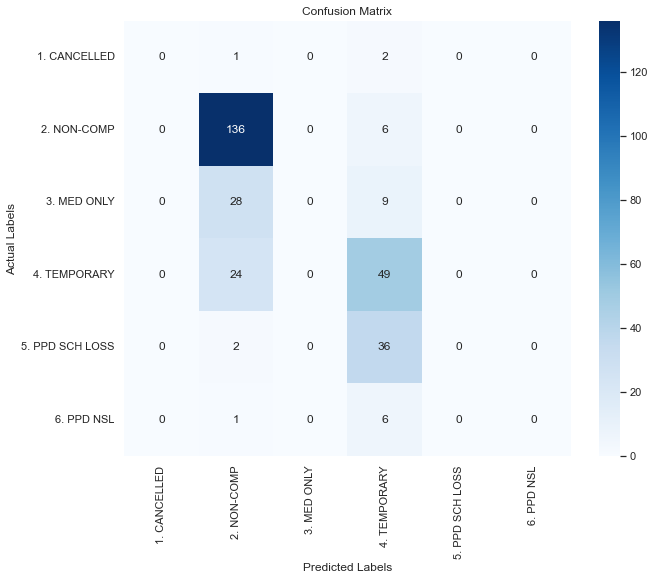

In [182]:
# Plot confusion matrix for test data
labels=target_encoder.classes_
conf_matrix_plot(y_test, y_test_pred_decoded_nn, labels)

In [183]:
# Predict on the submission test set
y_test_pred_nn = model_nn.predict(X_test_df_encode)
y_test_decoded_nn = target_encoder.inverse_transform(y_test_pred_nn)

In [73]:
unique_values, counts = np.unique(y_test_decoded_nn, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

2. NON-COMP: 138
4. TEMPORARY: 62


In [108]:
# Create a submission DataFrame
submission_nn = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_decoded_nn
})

# Save the submission file
submission_nn.to_csv('submission_nn.csv', index=False)
print("Submission file saved as 'submission_nn.csv'")

Submission file saved as 'submission_nn.csv'


### 2.6 Decision Trees <a id='dt'></a>
[to the top](#top)

In [29]:
# Create Decision Tree model
model_dt_default = DecisionTreeClassifier()
model_dt = DecisionTreeClassifier()

# Define hyperparameter grid
param_grid_dt = {
    "criterion": ["gini", "entropy", "log_loss"], # Impurity measure
    "splitter": ["best", "random"],               # Split strategy
    "max_depth": [None, 5, 10, 20],           # Maximum depth of the tree
    "min_samples_split": [2, 10, 50],             # Minimum samples required to split an internal node
    "min_samples_leaf": [1, 5, 10],           # Minimum samples required in a leaf node
    "max_features": [None, "sqrt", "log2"],       # Number of features to consider for best split
    "max_leaf_nodes": [None, 10, 20, 50],         # Maximum number of leaf nodes
    "min_impurity_decrease": [0.01, 0.02, 0.02]   # Decide if a node will be split according to the decrease of impurity
}

In [30]:
# Tune hyperparameters using the training set
best_params_dt = {
    'criterion': 'entropy',
    'max_depth': None,
    'max_features': None,
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.01,
    'min_samples_leaf': 5,
    'min_samples_split': 2,
    'splitter': 'random'
}

model_dt.set_params(**best_params_dt)

DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.01,
                       min_samples_leaf=5, splitter='random')

In [31]:
models_dt = [
    ("DT Default", model_dt_default),
    ("DT Best Params", model_dt)
]

In [32]:
# Train and evaluate on validation set
results_dt = compare_results(models_dt, X_train, X_val, y_train, y_val)
results_dt

Evaluating model: DT Default...
Evaluating model: DT Best Params...


Model  Time (s)  Train F1-Score  Validation F1-Score
0      DT Default     5.325           1.000                0.305
1  DT Best Params     0.421           0.244                0.243

In [33]:
# Evaluate on the test set
y_test_pred_dt = model_dt.predict(X_test)


# Calculate and save the F1 macro score on test for the best parameter model
test_f1_dt_best = round(f1_score(y_test, y_test_pred_dt, average='macro'), 3)
results_dt_best = results_dt[results_dt["Model"].str.contains("Best Params")].copy()
results_dt_best["Test F1-Score"] = test_f1_dt_best

# Classification report with the original labels
classification_report_print(y_test, y_test_pred_dt, 'Decision Tree Model')


Classification Report for Decision Tree Model:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2496
         1.0       0.80      1.00      0.89     58216
         2.0       0.00      0.00      0.00     13781
         3.0       0.67      0.89      0.76     29702
         4.0       0.80      0.20      0.32      9656
         5.0       0.00      0.00      0.00       842
         6.0       0.00      0.00      0.00        19
         7.0       0.00      0.00      0.00        94

    accuracy                           0.75    114806
   macro avg       0.28      0.26      0.25    114806
weighted avg       0.64      0.75      0.67    114806



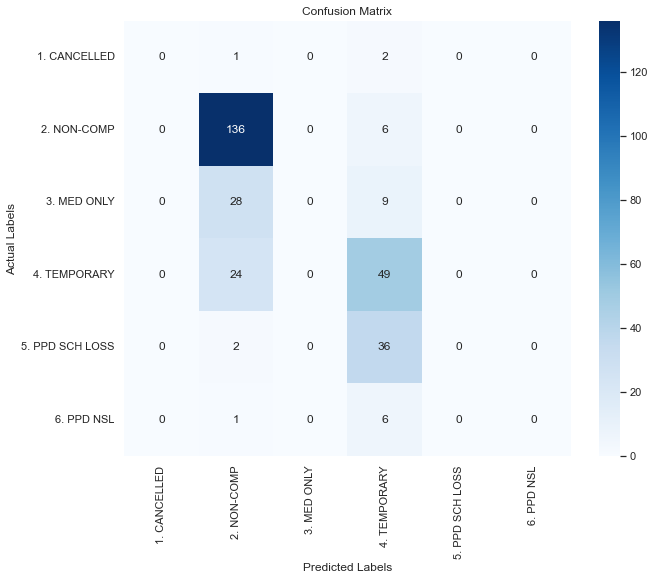

In [189]:
# Plot confusion matrix for test data
labels=target_encoder.classes_
conf_matrix_plot(y_test, y_test_pred_decoded_dt, labels)

In [190]:
# Predict on the submission test set
y_test_pred_dt = model_dt.predict(X_test_df_encode)
y_test_decoded_dt = target_encoder.inverse_transform(y_test_pred_dt)

In [191]:
unique_values, counts = np.unique(y_test_decoded_dt, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

2. NON-COMP: 192
4. TEMPORARY: 108


In [ ]:
# Create a submission DataFrame
submission_dt = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_decoded_dt
})

# Save the submission file
submission_dt.to_csv('submission_dt.csv', index=False)
print("Submission file saved as 'submission_dt.csv'")

### 2.7 Ensemble Learning <a id='el'></a>

In the following, we are going to use different kinds of Ensemble Learning methods. First, we are starting with Bagging and Random Forest, then we are using Boosting and XGBoost.

### 2.7.1 Bagging Classifier <a id='bagging'></a>
[to the top](#top)

We will use Decision Trees and KNN as base estimators, since they are the most used bagging base estimators.

In [35]:
# Create model
estimator_dt = DecisionTreeClassifier()
estimator_knn = KNeighborsClassifier()
model_bag_dt = BaggingClassifier(estimator=estimator_dt)
model_bag_knn = BaggingClassifier(estimator=estimator_knn)

# Define parameter grid
param_grid_bag = {
    "n_estimators": [10, 50, 100],       # Number of decision trees
    "max_samples": [0.5, 0.7, 1.0],      # Fraction of the dataset to sample
    "max_features": [0.5, 0.7, 1.0],     # Fraction of features to sample
    "bootstrap": [True, False],          # Sampling with or without replacement
    "bootstrap_features": [True, False]  # Feature sampling with or without replacement
}

In [40]:
# Tune hyperparameters using the training set
best_params_bag = {
    'bootstrap': False,
    'bootstrap_features': False,
    'max_features': 1.0,
    'max_samples': 0.7,
    'n_estimators': 100
}
model_bag_dt.set_params(**best_params_bag)

BaggingClassifier(bootstrap=False, estimator=DecisionTreeClassifier(),
                  max_samples=0.7, n_estimators=100)

In [36]:
# Tune hyperparameters using the training set
best_params_bag_knn = {
    'bootstrap': True,
    'bootstrap_features': False,
    'max_features': 1.0,
    'max_samples': 1.0,
    'n_estimators': 10
}
model_bag_knn.set_params(**best_params_bag_knn)

BaggingClassifier(estimator=KNeighborsClassifier())

In [41]:
models_bag = [
    ("Bagging DT Best Params", model_bag_dt),
    ("Bagging KNN Best Params", model_bag_knn)
]

In [42]:
# Train and evaluate on validation set
results_bag = compare_results(models_bag, X_train, X_val, y_train, y_val)
results_bag

Evaluating model: Bagging DT Best Params...
Evaluating model: Bagging KNN Best Params...


Model  Time (s)  Train F1-Score  Validation F1-Score
0   Bagging DT Best Params   349.602           1.000                0.337
1  Bagging KNN Best Params     1.728           0.418                0.320

In [48]:
# Evaluate on the test set
y_test_pred_bag_dt = model_bag_dt.predict(X_test)

# Decode predictions

# Calculate and save the F1 macro score on test for the best parameter model
test_f1_bag_best = round(f1_score(y_test, y_test_pred_bag_dt, average='macro'), 3)
results_bag_best = results_bag[results_bag["Model"].str.contains("DT Best Params")].copy()
results_bag_best["Test F1-Score"] = test_f1_bag_best

# Classification report with the original labels
classification_report_print(y_test, y_test_pred_bag_dt, 'Decision Tree Model')


Classification Report for Decision Tree Model:

              precision    recall  f1-score   support

         0.0       0.63      0.33      0.44      2496
         1.0       0.83      0.96      0.89     58216
         2.0       0.25      0.05      0.09     13781
         3.0       0.69      0.81      0.74     29702
         4.0       0.59      0.48      0.53      9656
         5.0       0.09      0.01      0.01       842
         6.0       0.00      0.00      0.00        19
         7.0       0.00      0.00      0.00        94

    accuracy                           0.75    114806
   macro avg       0.38      0.33      0.34    114806
weighted avg       0.69      0.75      0.71    114806



In [47]:
# Evaluate on the test set
y_test_pred_bag_knn = model_bag_knn.predict(X_test)

# Decode predictions

# Calculate and save the F1 macro score on test for the best parameter model
test_f1_bag_best = round(f1_score(y_test, y_test_pred_bag_knn, average='macro'), 3)
results_bag_best = results_bag[results_bag["Model"].str.contains("DT Best Params")].copy()
results_bag_best["Test F1-Score"] = test_f1_bag_best

# Classification report with the original labels
classification_report_print(y_test, y_test_pred_bag_knn, 'Decision Tree Model')


Classification Report for Decision Tree Model:

              precision    recall  f1-score   support

         0.0       0.51      0.23      0.32      2496
         1.0       0.82      0.95      0.88     58216
         2.0       0.21      0.06      0.09     13781
         3.0       0.69      0.77      0.73     29702
         4.0       0.55      0.46      0.50      9656
         5.0       0.01      0.00      0.00       842
         6.0       0.00      0.00      0.00        19
         7.0       0.00      0.00      0.00        94

    accuracy                           0.73    114806
   macro avg       0.35      0.31      0.31    114806
weighted avg       0.67      0.73      0.69    114806



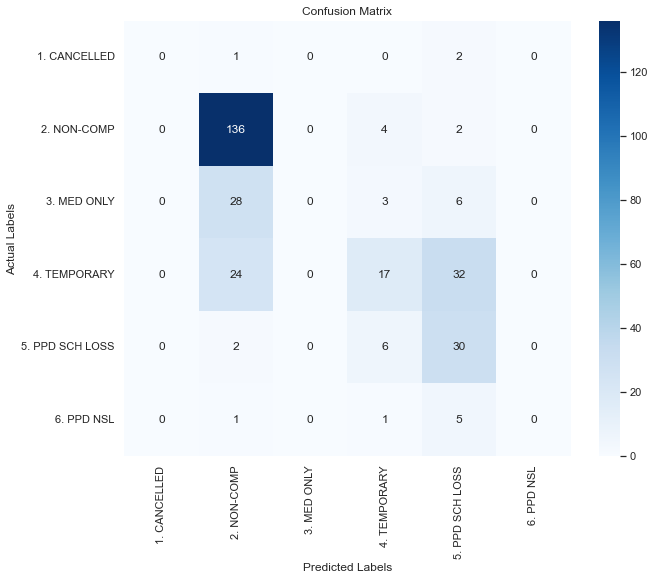

In [198]:
# Plot confusion matrix for test data
labels=target_encoder.classes_
conf_matrix_plot(y_test, y_test_pred_decoded_bag_dt, labels)

In [121]:
# Predict on the submission test set
y_test_pred_bag_dt = model_bag_dt.predict(X_test_df_encode)
y_test_decoded_bag_dt = target_encoder.inverse_transform(y_test_pred_bag_dt)

In [122]:
unique_values, counts = np.unique(y_test_decoded_bag_dt, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

2. NON-COMP: 138
4. TEMPORARY: 18
5. PPD SCH LOSS: 44


In [ ]:
# Create a submission DataFrame
submission_bag_dt = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_decoded_bag_dt
})

# Save the submission file
submission_bag_dt.to_csv('submission_bag_dt.csv', index=False)
print("Submission file saved as 'submission_bag_dt.csv'")

### 2.7.2 Random Forest Classifier <a id='random_forest'></a>
[to the top](#top)

Step 1: Create models and define hyperparameter grid for Random Forest Classifier

In [52]:
# Create model
model_rf_default = RandomForestClassifier()
model_rf = RandomForestClassifier()

# Define hyperparameter grid
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

Step 2: Perform hyperparameter tuning

In [200]:
# Tune hyperparameters using the training set
best_params_rf = hyperparameter_tuning(model_rf, param_grid_rf, test_fold, X_combined, y_combined)
model_rf.set_params(**best_params_rf)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
The best score is 0.2594146898182114
With the parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


RandomForestClassifier(n_estimators=50)

Step 3: Train default model and model with best parameter setting and evaluate

In [201]:
models_rf = [
    ("RF Default", model_rf_default),
    ("RF Best Params", model_rf)
]

In [202]:
# Train and evaluate on the validation dataset
results_rf = compare_results(models_rf, X_train_df_encode, X_val_df_encode, y_train_df_encode, y_val_df_encode)
results_rf

Evaluating model: RF Default...
Evaluating model: RF Best Params...


Model  Time (s)  Train F1-Score  Validation F1-Score
0      RF Default     0.092           0.224                0.259
1  RF Best Params     0.043           0.182                0.210

Step 4: Evaluate the chosen model on our Test Set

In [203]:
# Evaluate on the test set
y_test_pred_rf = model_rf.predict(X_test_df_encode)

# Decode predictions
y_test_pred_decoded_rf = target_encoder.inverse_transform(y_test_pred_rf)

# Calculate and save the F1 macro score on test for the best parameter model
test_f1_rf_best = round(f1_score(y_test, y_test_pred_decoded_rf, average='macro'), 3)
results_rf_best = results_rf[results_rf["Model"].str.contains("Best Params")].copy()
results_rf_best["Test F1-Score"] = test_f1_rf_best

# Classification report with the original labels
classification_report_print(y_test, y_test_pred_decoded_rf, 'Random Forrest Classifier')


Classification Report for Random Forrest Classifier:

                 precision    recall  f1-score   support

   1. CANCELLED       0.00      0.00      0.00         3
    2. NON-COMP       0.71      0.96      0.81       142
    3. MED ONLY       0.00      0.00      0.00        37
   4. TEMPORARY       0.45      0.67      0.54        73
5. PPD SCH LOSS       0.00      0.00      0.00        38
     6. PPD NSL       0.00      0.00      0.00         7

       accuracy                           0.62       300
      macro avg       0.19      0.27      0.23       300
   weighted avg       0.45      0.62      0.52       300



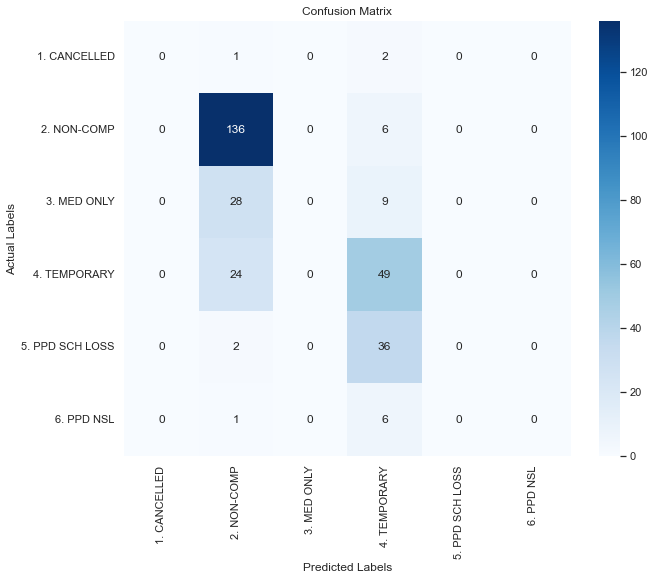

In [204]:
# Plot confusion matrix for test data
labels=target_encoder.classes_
conf_matrix_plot(y_test, y_test_pred_decoded_rf, labels)

__Findings (need to be updated):__
- __Improvement in Certain Classes:__ The random forest classifier is showing better predictions for classes like "CANCELLED" and "TEMPORARY," as evidenced by more instances being correctly classified. For instance, 975 instances of "CANCELLED" and 130,497 instances of "TEMPORARY" are correctly predicted, which is an improvement over the logistic regression results.
- __Persistent Bias Toward Majority Classes:__ Similar to the logistic regression model, the random forest is heavily biased towards the majority class, "NON-COMP." It classifies a large number of instances into this category, which may indicate that the model still struggles with the imbalanced distribution of classes.
- __Challenges with Rare Classes:__ Similar to the logistic regression model, the random forest struggles with rare classes like "PPD NSL," "PTD," and "DEATH." These classes have very few correct predictions, indicating that the model has not learned to recognize their unique patterns well. This might be due to the insufficient representation of these classes in the training data

Step 5: Prediction on Submission Test Data

In [96]:
y_test_pred_rf = model_rf.predict(X_test_df_encode)
y_test_decoded_rf = target_encoder.inverse_transform(y_test_pred_rf)

In [95]:
unique_values, counts = np.unique(y_test_decoded_rf, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

2. NON-COMP: 138
4. TEMPORARY: 62


In [ ]:
# Create a submission DataFrame
submission_rf = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_decoded_rf
})

# Save the submission file
submission_rf.to_csv('submission_rf.csv', index=False)
print("Submission file saved as 'submission_rf.csv'")

Submission file saved as 'submission_rf.csv'


### 2.7.3 XGBoost <a id='xgboost'></a>
[to the top](#top)

Step 1: Create models and define hyperparameter grid for XGBoost Classifier

In [49]:
# Initialize XGBoost classifier
model_xgb = XGBClassifier(objective='multi:softprob', num_class=8, use_label_encoder=False, eval_metric='mlogloss')
model_xgb_default = XGBClassifier()

# Define hyperparameter grid
param_grid_xgb = {
    'max_depth': [2, 3, 5],                 # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.15],     # Step size shrinkage
    'n_estimators': [50, 100, 150],         # Number of boosting rounds
    'subsample': [0.8, 1.0],                # Fraction of samples for each tree
    'colsample_bytree': [0.6, 0.8, 0.9]     # Fraction of features for each tree
}

Step 2: Perform hyperparameter tuning

In [50]:
# Tune hyperparameters using the training set
best_params_xgb = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.15,
    'max_depth': 5,
    'n_estimators': 150,
    'subsample': 0.8
}
model_xgb.set_params(**best_params_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.15, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_class=8, num_parallel_tree=None, ...)

Step 3: Train default model and model with best parameter setting and evaluate

In [51]:
models_xgb = [
    ("XGBoost Default", model_xgb_default),
    ("XGBoost Best Params", model_xgb)
]

In [52]:
# Train and evaluate on validation set
results_xgb = compare_results(models_xgb, X_train, X_val, y_train, y_val)
results_xgb

Evaluating model: XGBoost Default...
Evaluating model: XGBoost Best Params...


Model  Time (s)  Train F1-Score  Validation F1-Score
0      XGBoost Default    11.947           0.502                0.342
1  XGBoost Best Params    20.062           0.385                0.349

Step 4: Evaluate the chosen model on our Test Set

In [53]:
# Evaluate on the test set
y_test_pred_xgb = model_xgb.predict(X_test)


# Calculate and save the F1 macro score on test for the best parameter model
test_f1_xgb_best = round(f1_score(y_test, y_test_pred_xgb, average='macro'), 3)
results_xgb_best = results_xgb[results_xgb["Model"].str.contains("Best Params")].copy()
results_xgb_best["Test F1-Score"] = test_f1_xgb_best

# Classification report with the original labels
classification_report_print(y_test, y_test_pred_xgb, 'XGBoost Classifier')


Classification Report for XGBoost Classifier:

              precision    recall  f1-score   support

         0.0       0.69      0.29      0.41      2496
         1.0       0.81      0.99      0.89     58216
         2.0       0.38      0.01      0.02     13781
         3.0       0.70      0.84      0.77     29702
         4.0       0.66      0.48      0.56      9656
         5.0       0.00      0.00      0.00       842
         6.0       0.00      0.00      0.00        19
         7.0       0.62      0.05      0.10        94

    accuracy                           0.77    114806
   macro avg       0.48      0.33      0.34    114806
weighted avg       0.71      0.77      0.71    114806



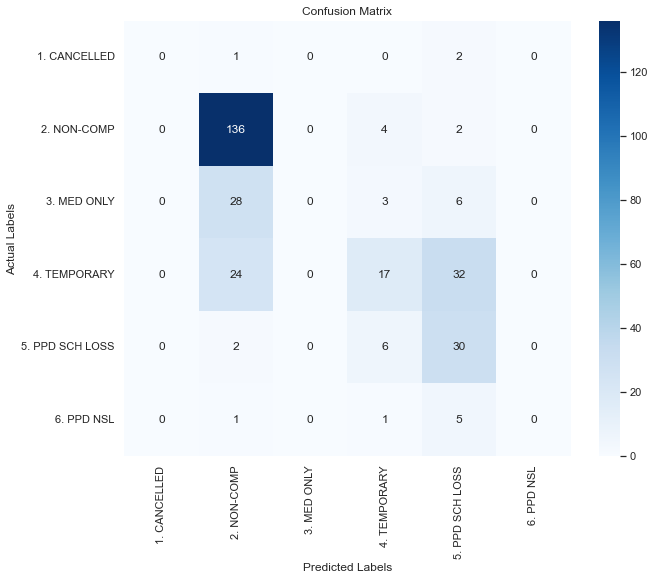

In [210]:
# Plot confusion matrix for test data
labels=target_encoder.classes_
conf_matrix_plot(y_test, y_test_pred_decoded_xgb, labels)

__Findings:__
- __X:__ y

Step 5: Prediction on Submission Test Data

In [103]:
y_test_pred_xgb = model_rf.predict(X_test_df_encode)
y_test_decoded_xgb = target_encoder.inverse_transform(y_test_pred_xgb)

In [123]:
unique_values, counts = np.unique(y_test_decoded_xgb, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

2. NON-COMP: 138
4. TEMPORARY: 62


In [ ]:
# Create a submission DataFrame
submission_xgb = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_decoded_xgb
})

# Save the submission file
submission_xgb.to_csv('submission_xgb.csv', index=False)
print("Submission file saved as 'submission_xgb.csv'")

### 2.8 Support Vector Machines <a id='svm'></a>
[to the top](#top)

In [62]:
# Create model
model_svm_default = SVC(kernel='linear', decision_function_shape='ovr')
model_svm = SVC(kernel='linear', decision_function_shape='ovr') #decision_function_shape='ovr' -> to use svm for multicalss classification

param_grid_svm = {
    "C": [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    "tol": [1e-4, 1e-3, 1e-2],     # Tolerance for stopping criteria
    "max_iter": [1000, 5000, -1],  # Limit on iterations (-1 for no limit)
}

In [ ]:
# Tune hyperparameters using the training set
best_params_svm = hyperparameter_tuning(model_svm, param_grid_svm, test_fold, X_combined, y_combined)
model_svm.set_params(**best_params_svm)

Fitting 1 folds for each of 45 candidates, totalling 45 fits


In [213]:
models_svm = [
    ("SVM Default", model_svm_default),
    ("SVM Best Params", model_svm)
]

In [214]:
# Train and evaluate on validation set
results_svm = compare_results(models_svm, X_train_df_encode, X_val_df_encode, y_train_df_encode, y_val_df_encode)
results_svm

Evaluating model: SVM Default...
Evaluating model: SVM Best Params...


Model  Time (s)  Train F1-Score  Validation F1-Score
0      SVM Default     0.024           0.182                 0.21
1  SVM Best Params     0.034           0.182                 0.21

In [215]:
# Evaluate on the test set
y_test_pred_svm = model_svm.predict(X_test_df_encode)

# Decode predictions
y_test_pred_decoded_svm = target_encoder.inverse_transform(y_test_pred_svm)

# Calculate and save the F1 macro score on test for the best parameter model
test_f1_svm_best = round(f1_score(y_test, y_test_pred_decoded_svm, average='macro'), 3)
results_svm_best = results_svm[results_svm["Model"].str.contains("Best Params")].copy()
results_svm_best["Test F1-Score"] = test_f1_svm_best

# Classification report with the original labels
classification_report_print(y_test, y_test_pred_decoded_svm, 'Support Vector Machine')


Classification Report for Support Vector Machine:

                 precision    recall  f1-score   support

   1. CANCELLED       0.00      0.00      0.00         3
    2. NON-COMP       0.71      0.96      0.81       142
    3. MED ONLY       0.00      0.00      0.00        37
   4. TEMPORARY       0.45      0.67      0.54        73
5. PPD SCH LOSS       0.00      0.00      0.00        38
     6. PPD NSL       0.00      0.00      0.00         7

       accuracy                           0.62       300
      macro avg       0.19      0.27      0.23       300
   weighted avg       0.45      0.62      0.52       300



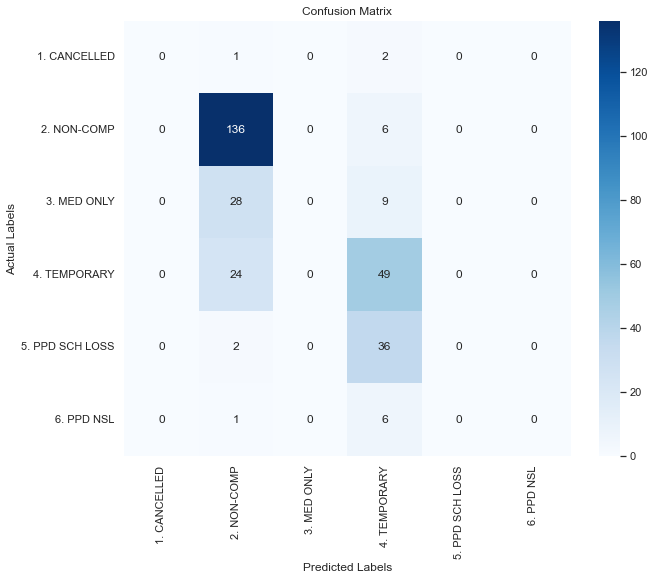

In [216]:
# Plot confusion matrix for test data
labels=target_encoder.classes_
conf_matrix_plot(y_test, y_test_pred_decoded_svm, labels)

__Findings:__
- __X:__ y

In [135]:
# Prediction on Submission Test Data
y_test_pred_svm = model_svm.predict(X_test_df_encode)
y_test_decoded_svm = target_encoder.inverse_transform(y_test_pred_svm)

In [136]:
unique_values, counts = np.unique(y_test_decoded_svm, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

2. NON-COMP: 138
4. TEMPORARY: 62


In [ ]:
# Create a submission DataFrame
submission_svm = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_decoded_svm
})

# Save the submission file
submission_svm.to_csv('submission_svm.csv', index=False)
print("Submission file saved as 'submission_svm.csv'")

### 3. Comparison of all Models <a id='comparison'></a>
[to the top](#top)

Now, we are comparing the results of all models to decide which one is overall the best model.

In [58]:
# Combine all results
results_combined = pd.concat([results_lr_best, results_knn_best, results_nn_best, results_dt_best, results_bag_best, results_xgb_best], axis=0).reset_index(drop=True)

results_combined["Algorithm"] = sum([["Logistic Regression"], ["K-Nearest Neighbor"], ["Neural Networks"], ["Decision Trees"], ["DT Bagging Ensemble"], ["XGBoost Classifier"]], [])

results_combined = results_combined[["Algorithm", "Model", "Time (s)", "Train F1-Score", "Validation F1-Score", "Test F1-Score"]]
results_combined

Algorithm                   Model  Time (s)  Train F1-Score  \
0  Logistic Regression          LR Best Params    11.977           0.275   
1   K-Nearest Neighbor         KNN Best Params     0.071           1.000   
2      Neural Networks          NN Best Params   132.885           0.303   
3       Decision Trees          DT Best Params     0.421           0.244   
4  DT Bagging Ensemble  Bagging DT Best Params   349.602           1.000   
5   XGBoost Classifier     XGBoost Best Params    20.062           0.385   

   Validation F1-Score  Test F1-Score  
0                0.280          0.285  
1                0.324          0.315  
2                0.304          0.306  
3                0.243          0.246  
4                0.337          0.337  
5                0.349          0.343

### 4. Feature Importance <a id='feature_importance'></a>
[to the top](#top)

_DEPENDS ON WHICH OUR FINAL BEST MODEL IS_

XGBoost, Decision Tree and Random Forest have in-built featzre importance. For Logistic Regression we can use "coef_" for importance.

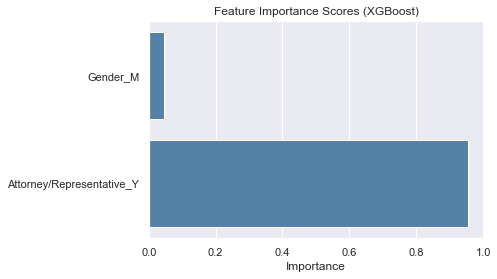

In [218]:
# Feature importance of XGBoost
feature_importance = model_xgb.feature_importances_

feature_names = list(X_train_df_encode.columns)

sns.barplot(x=feature_importance, y=feature_names, color="steelblue")

plt.title("Feature Importance Scores (XGBoost)")
plt.xlabel("Importance")

plt.show()

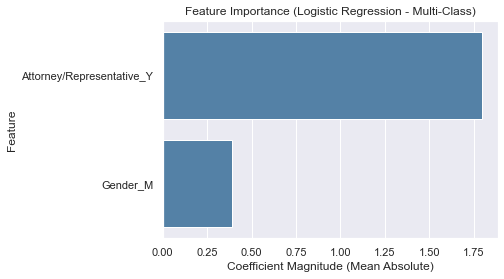

In [124]:
# Feature Importance Logistic Regression Coefficients
# Get feature importance by aggregating across all classes
feature_importance = np.mean(np.abs(model_lr.coef_), axis=0)

feature_names = list(X_train_df_encode.columns)

importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
sns.barplot(x="Importance", y="Feature", data=importance_df, color="steelblue")
plt.title("Feature Importance (Logistic Regression - Multi-Class)")
plt.xlabel("Coefficient Magnitude (Mean Absolute)")
plt.show()

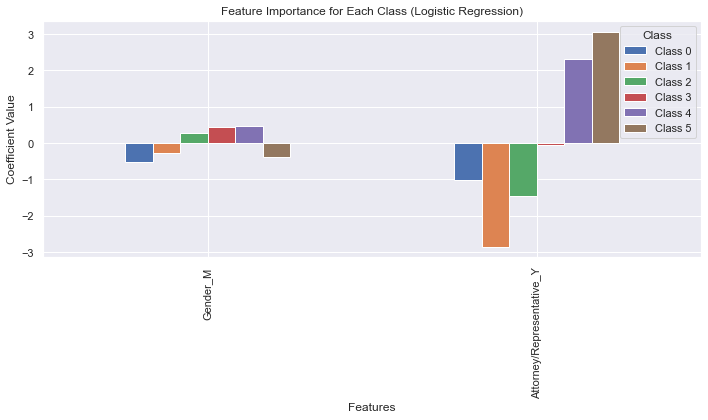

In [125]:
# Get feature importance for each class
coefs_per_class = model_lr.coef_  # Shape: (n_classes, n_features)
n_classes = coefs_per_class.shape[0]

importance_df = pd.DataFrame(coefs_per_class.T, columns=[f"Class {i}" for i in range(n_classes)], index=feature_names)

# Plot coefficients per class
importance_df.plot(kind="bar", figsize=(10, 6))
plt.title("Feature Importance for Each Class (Logistic Regression)")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.legend(title="Class")
plt.tight_layout()
plt.show()

### 5. Best Model vs. Stacking <a id='stacking'></a>
[to the top](#top)

_Create a stackling model, combining different (!!) models and try to outperform our best model from the previous section_

_Ricardo said we should include a Naive Bayes in the Stacking (because he loves them) and other models that differ from another, e.g., Decision Tree, KNN, MLP and SVM. He also said that this will probably be the best performing model._

In [219]:
# Define base models -> use the best parameter models
base_models = {
    'Naive Bayes': model_multi_nb,
    'Decision Tree': model_dt,
    'KNN': model_knn,
    'SVM': model_svm
}

# Prepare meta-features
meta_features = np.zeros((len(y_train), len(base_models)))
meta_test_features = np.zeros((len(y_test), len(base_models)))

for i, (name, model) in enumerate(base_models.items()):
    # Train base model on training set
    model.fit(X_train_df_encode, y_train_df_encode)
    
    # Predict on train and test to generate meta-features
    meta_features[:, i] = model.predict(X_train_df_encode)
    meta_test_features[:, i] = model.predict(X_test_df_encode)

# Train meta-model
meta_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
meta_model.fit(meta_features, y_train_df_encode)


# Evaluate meta-model with F1 Macro Score
final_preds = meta_model.predict(meta_test_features)
y_test_decoded_final_preds = target_encoder.inverse_transform(final_preds)
f1_macro = f1_score(y_test, y_test_decoded_final_preds, average='macro')

print(f"Stacking Ensemble F1 Macro Score on Test Set: {f1_macro:.2f}")

Stacking Ensemble F1 Macro Score on Test Set: 0.23
